In [2]:
import pandas as pd 
df = pd.read_excel("Əsas data.xlsx", sheet_name="Əsas data")

df["Order Date"] = pd.to_datetime(df["Order Date"])
df.head(5)

,Region,Country,City,State,Market,Category,Sub-Category,Product ID,Product Name,Customer ID,...,Order Date,Ship Mode,Ship Date,Order Priority,Segment,Sales,Shipping Cost,Profit,Quantity,Discount
0,Africa,Algeria,Constantine,Constantine,EMEA,Office Supplies,Storage,OFF-TEN-10000025,"Tenex Lockers, Blue",TB-112801,...,2011-01-01,Standard Class,2011-06-01 00:00:00,Medium,Consumer,408.30,35.46,106.14,2,0.0
1,Africa,Tanzania,Dar es Salaam,Dar Es Salaam,EMEA,Office Supplies,Supplies,OFF-STI-10000388,"Stiletto Scissors, Serrated",JG-51151,...,2011-03-01,Standard Class,2011-08-01 00:00:00,Medium,Consumer,81.24,5.11,26.76,4,0.0
2,Africa,Sudan,Khartoum,Khartoum,EMEA,Office Supplies,Art,OFF-BOS-10004950,"Boston Pens, Fluorescent",JC-53401,...,2011-04-01,Standard Class,2011-08-01 00:00:00,Medium,Consumer,15.48,0.82,2.61,1,0.0
3,Africa,Sudan,Khartoum,Khartoum,EMEA,Office Supplies,Binders,OFF-AVE-10003279,"Avery Hole Reinforcements, Durable",JC-53401,...,2011-04-01,Standard Class,2011-08-01 00:00:00,Medium,Consumer,5.91,0.51,2.10,1,0.0
4,Africa,Angola,Luanda,Luanda,EMEA,Technology,Accessories,TEC-LOG-10003079,"Logitech Flash Drive, Erganomic",GK-46201,...,2011-06-01,Standard Class,2011-11-01 00:00:00,Medium,Corporate,28.32,2.00,12.72,1,0.0


In [3]:
current_day = df["Order Date"].max() + pd.Timedelta(days=1)

In [6]:
rfm_df = df.groupby("Customer ID").agg({
    "Order Date": lambda x: (current_day - x.max()).days, # Recency
    "Order ID" : "nunique",                               # Frequency
    "Sales" : "sum"                                       # Monetary
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [12]:
rfm_df["R_Score"] = pd.qcut(rfm_df["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm_df["F_Score"] = pd.qcut(rfm_df["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm_df["M_Score"] = pd.qcut(rfm_df["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

rfm_df['RFM_Score'] = (
    rfm_df['R_Score'].astype(str) +
    rfm_df['F_Score'].astype(str) +
    rfm_df['M_Score'].astype(str)
)

rfm_df.head(5)


,CustomerID,Recency,Frequency,Monetary,F_Score,M_Score,R_Score,RFM_Score
0,AA-103151,9,5,1445.406,3,3,5,533
1,AA-103152,14,7,6105.627,4,5,5,545
2,AA-103153,609,2,632.820,1,2,1,112
3,AA-103154,185,5,5563.560,3,5,2,235
4,AA-103751,7,4,2407.245,2,3,5,523


In [16]:
def segment(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'VIP'
    elif row['R_Score'] >= 4:
        return 'Recent'
    elif row['F_Score'] >= 4:
        return 'Frequent'
    elif row['M_Score'] >= 4:
        return 'High Value'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2 and row['M_Score'] <= 2:
        return 'At Risk'
    else:
        return 'Others'
rfm_df["Segment"] = rfm_df.apply(segment,axis=1)

In [18]:
segment_counts = rfm_df["Segment"].value_counts().sort_values(ascending=False)

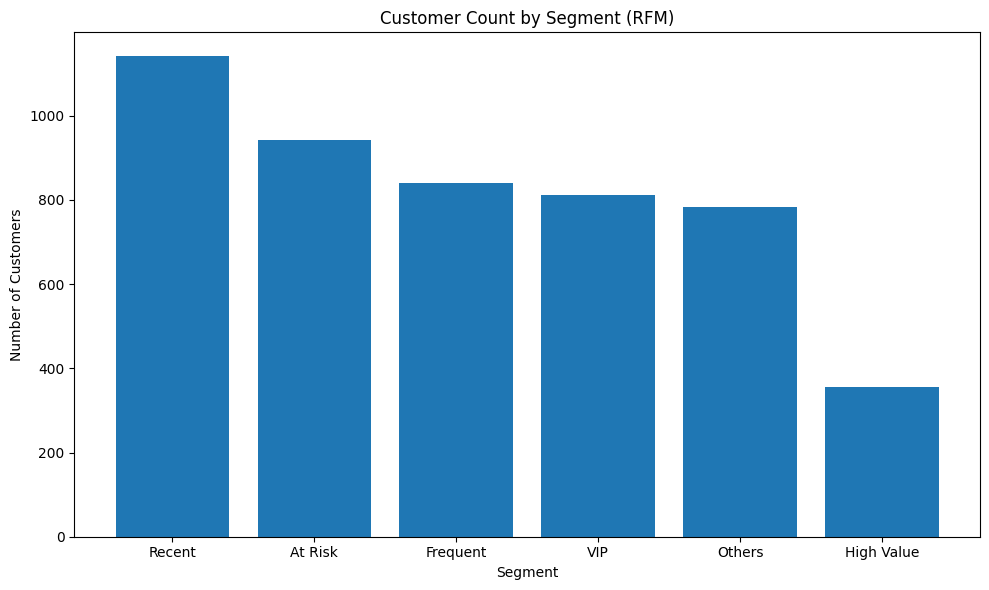

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(segment_counts.index, segment_counts.values)

plt.xlabel('Segment')
plt.ylabel('Number of Customers')

plt.title('Customer Count by Segment (RFM)')
plt.tight_layout()
plt.show()


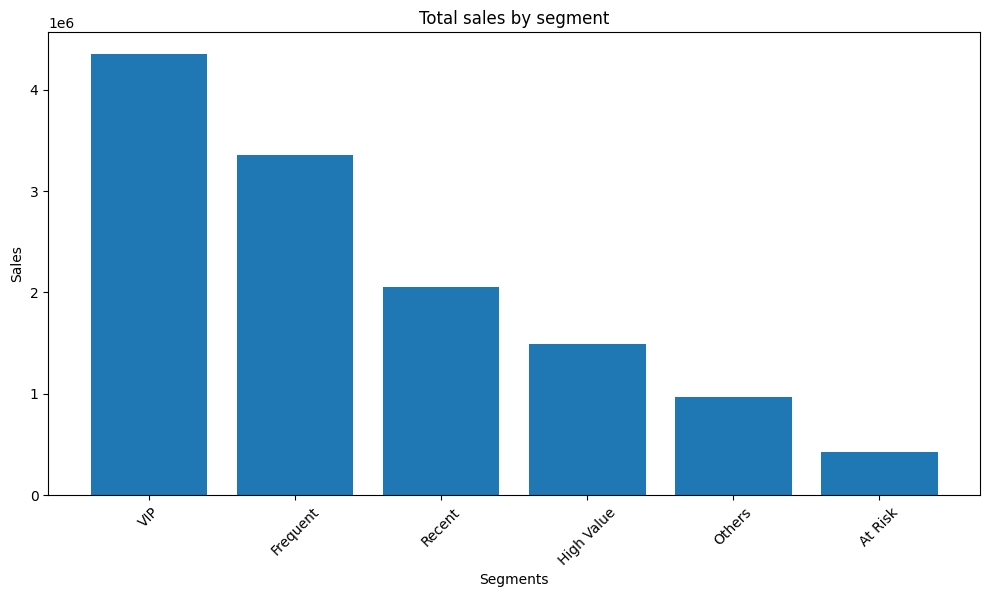

In [29]:
segment_sales = rfm_df.groupby("Segment")["Monetary"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(segment_sales.index, segment_sales.values)
plt.xlabel("Segments")
plt.ylabel("Sales")
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.title("Total sales by segment")
plt.show()